In [ ]:
we have 78 letters

In [2]:
#dowload data
import json

with open("ww1letters.json", "r", encoding="utf-8") as f:
    letters = json.load(f)


In [3]:
#get the list of letter keys
letterkeys = list(letters.keys())
print(letterkeys)

['arc71', 'hl_01', 'hl_02', 'hl_03a', 'hl_03b', 'hl_04', 'hl_05', 'hl_06', 'hl_07', 'hl_08', 'hl_09', 'hl_10', 'hl_11', 'hl_12', 'hl_13', 'hl_14', 'hl_15', 'hl_16', 'hl_17', 'hl_18', 'na_uk_01', 'na_uk_02', 'na_uk_03', 'na_uk_04', 'na_uk_05', 'na_uk_06', 'na_uk_07', 'na_uk_08', 'na_uk_09', 'na_uk_10', 'na_uk_11', 'na_uk_12', 'na_uk_13', 'na_uk_14', 'na_uk_15', 'na_uk_16', 'na_uk_17', 'na_uk_18', 'na_uk_19', 'na_uk_20', 'na_uk_21', 'na_uk_22', 'na_uk_23', 'na_uk_24', 'na_uk_25', 'na_uk_26', 'na_uk_27', 'na_uk_28', 'na_uk_29', 'na_uk_30', 'na_uk_31', 'na_uk_32', 'na_uk_33', 'na_uk_34', 'na_uk_35', 'na_uk_36', 'na_uk_37', 'na_uk_38', 'na_uk_39', 'na_uk_40', 'na_uk_41', 'na_uk_42', 'na_uk_43', 'na_uk_44', 'na_uk_45', 'na_uk_46', 'na_uk_47', 'na_uk_48', 'na_uk_49', 'na_uk_50', 'na_uk_51', 'na_uk_52', 'na_uk_53', 'na_uk_54', 'uk_na_55', 'new1', 'new2', 'new3']


In [4]:
lettervalues = list(letters.values())
#get the letters

In [5]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
stop_words = set(stopwords.words('english'))

def preprocess_texts(text_list):
    processed = []
    for text in text_list:
        # Lowercase the text
        text = text.lower()
        # Tokenize into words and punctuation using regex
        tokens = re.findall(r"\w+|[^\w\s]", text)
        # Remove stopwords
        filtered_tokens = [token for token in tokens if token not in stop_words]
        processed.append(filtered_tokens)
    return processed

# Example usage
texts = [
    "This is a sample text.\nIt has new lines!",
    "Another example: with STOPWORDS, and some\nNEW lines..."
]

result = preprocess_texts(texts)
print(result)

tokenizedletters = preprocess_texts(lettervalues)

[['sample', 'text', '.', 'new', 'lines', '!'], ['another', 'example', ':', 'stopwords', ',', 'new', 'lines', '.', '.', '.']]


In [26]:
#need to get total number of words
#flatten tokenizedletters
from itertools import chain
#convert to set and back to list
words = list(set(chain(*tokenizedletters)))
print(len(words))

4788


In [16]:
#tokenize preprocessed

#for each tokenized letter make a counter
from collections import Counter

#for each letter 
countletters = {}
for i, letter in enumerate(tokenizedletters):
    countedletter = Counter(letter)
    countletters[letterkeys[i]] = dict(countedletter)

#print(countletters)

{'arc71': {'mercredi': 1, '29': 1, 'septembre': 1, '1915': 1, 'chère': 1, 'louisette': 1, ',': 35, 'je': 9, "'": 41, 'ai': 2, 'promis': 1, 'presque': 4, 'solennellement': 1, 'de': 25, 'te': 2, 'dire': 1, 'la': 10, 'vérité': 1, ';': 23, 'vais': 1, 'exécuter': 1, 'mais': 6, 'en': 7, 'revanche': 1, 'tu': 3, 'donné': 1, 'l': 8, 'assurance': 1, 'que': 4, 'aurais': 1, 'les': 17, 'nerfs': 1, 'solides': 1, 'et': 22, 'le': 10, 'coeur': 1, 'ferme': 1, '.': 18, 'suis': 2, 'depuis': 3, 'ce': 4, 'matin': 2, 'dans': 5, 'des': 4, 'tranchées': 2, 'conquises': 1, '2': 3, 'jours': 2, 'ensemble': 1, 'ces': 3, 'boyaux': 5, 'forme': 1, 'un': 7, 'véritable': 1, '"': 2, 'labyrinthe': 1, 'où': 3, 'j': 6, 'erré': 1, '3': 2, 'heures': 2, 'cette': 1, 'nuit': 2, 'absolument': 2, 'perdu': 1, 'traces': 1, 'lutte': 1, 'ardente': 1, 'sont': 8, 'nombreuses': 1, 'saisissantes': 1, 'abord': 2, 'elles': 5, 'plus': 5, 'qu': 2, 'à': 7, 'moitié': 1, 'détruites': 1, 'par': 5, 'ouragan': 1, 'mitraille': 1, 'notre': 1, 'artill

In [27]:
# populate matrix 
import numpy as np
letters = sorted(countletters.keys())
bwMat = np.zeros((len(letters), len(words)))

for ib,letter in enumerate(letters):
    for w, v in countletters[letter].items():
        bwMat[ib, words.index(w)] = v
        
print(bwMat)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
#AAAAAAAAAAAAA

In [32]:
# The hierarchical clustering encoded as a linkage matrix.
#average linkage best
import scipy
distMat = scipy.spatial.distance.pdist(bwMat, "correlation")
linkage_matrix = scipy.cluster.hierarchy.average(distMat)


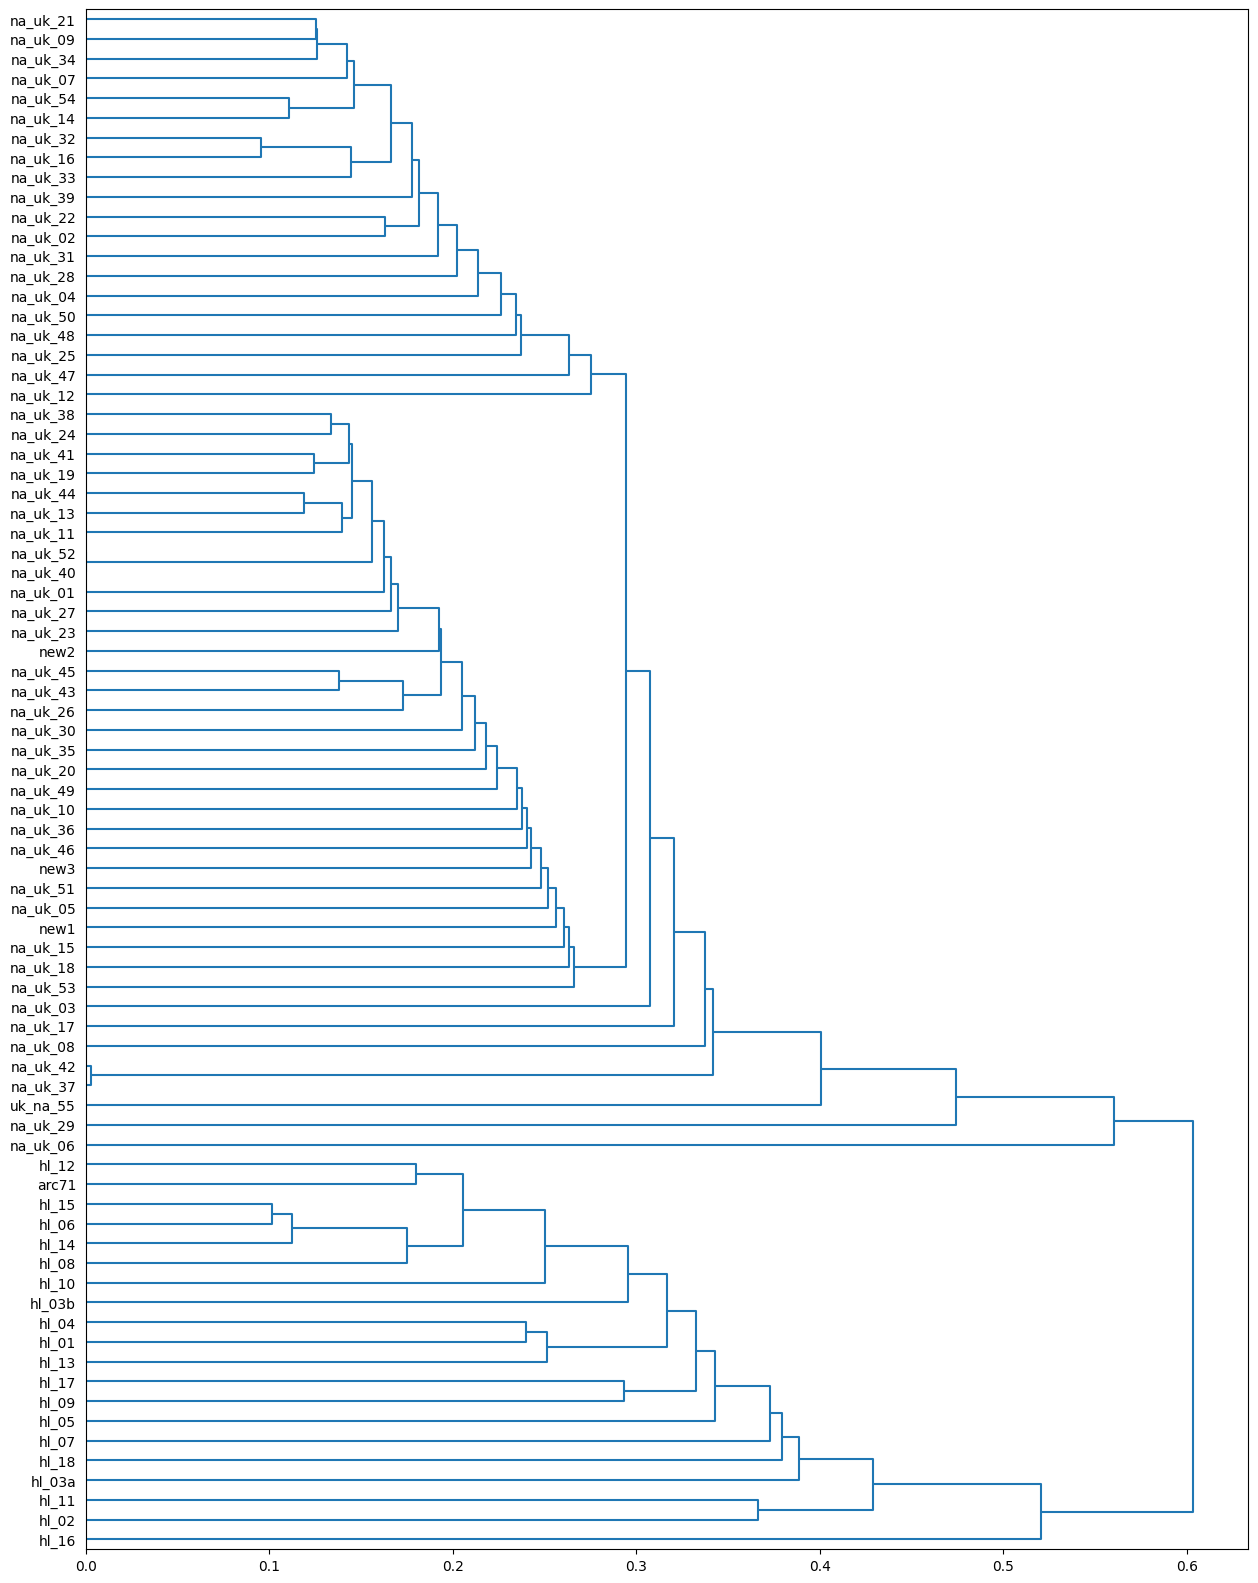

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 20))

# now with leafs on the left, and the root node on the right
scipy.cluster.hierarchy.dendrogram(linkage_matrix, labels = letters, color_threshold  = 0, orientation = 'right',
                                  leaf_font_size = 10)

plt.show()

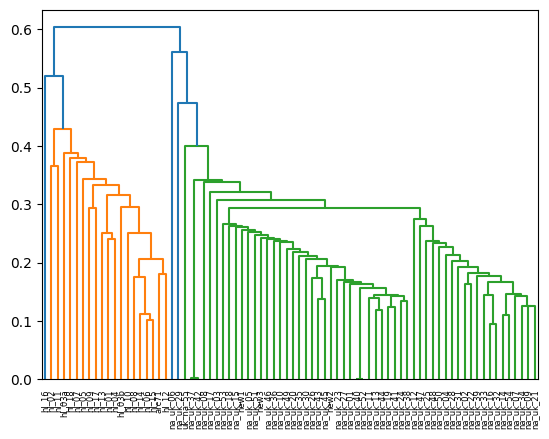

In [40]:
max_d = 0.75 * max(linkage_matrix[:,2])
scipy.cluster.hierarchy.dendrogram(linkage_matrix, labels = letters, color_threshold = max_d)

plt.show()

In [41]:
clusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, max_d, criterion = "distance")
print(clusters)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3]


In [44]:
# printing the contents of each cluster
from collections import defaultdict

cluster2blog = defaultdict(list)
for bid, clusterid in enumerate(clusters):
    cluster2blog[clusterid].append(letters[bid])

for cId, blog in cluster2blog.items():
    print(cId, blog)

1 ['arc71', 'hl_01', 'hl_02', 'hl_03a', 'hl_03b', 'hl_04', 'hl_05', 'hl_06', 'hl_07', 'hl_08', 'hl_09', 'hl_10', 'hl_11', 'hl_12', 'hl_13', 'hl_14', 'hl_15', 'hl_17', 'hl_18']
2 ['hl_16']
3 ['na_uk_01', 'na_uk_02', 'na_uk_03', 'na_uk_04', 'na_uk_05', 'na_uk_07', 'na_uk_08', 'na_uk_09', 'na_uk_10', 'na_uk_11', 'na_uk_12', 'na_uk_13', 'na_uk_14', 'na_uk_15', 'na_uk_16', 'na_uk_17', 'na_uk_18', 'na_uk_19', 'na_uk_20', 'na_uk_21', 'na_uk_22', 'na_uk_23', 'na_uk_24', 'na_uk_25', 'na_uk_26', 'na_uk_27', 'na_uk_28', 'na_uk_30', 'na_uk_31', 'na_uk_32', 'na_uk_33', 'na_uk_34', 'na_uk_35', 'na_uk_36', 'na_uk_37', 'na_uk_38', 'na_uk_39', 'na_uk_40', 'na_uk_41', 'na_uk_42', 'na_uk_43', 'na_uk_44', 'na_uk_45', 'na_uk_46', 'na_uk_47', 'na_uk_48', 'na_uk_49', 'na_uk_50', 'na_uk_51', 'na_uk_52', 'na_uk_53', 'na_uk_54', 'new1', 'new2', 'new3', 'uk_na_55']
5 ['na_uk_06']
4 ['na_uk_29']


In [ ]:
AAAAAA  YOU FUCKED UP EARLIERRRR AAA


In [49]:
import nltk
from nltk.corpus import wordnet as wn


# Map universal POS tags to WordNet POS tags
un2wn_mapping = {
    "VERB": wn.VERB,
    "NOUN": wn.NOUN,
    "ADJ": wn.ADJ,
    "ADV": wn.ADV
}

lemmatizer = nltk.WordNetLemmatizer()

def preprocess_letters(letter_list):
    processed_letters = []

    for letter in letter_list:
        lemmatized_letter = []

        # Split by newlines and tokenize (also splits by spaces)
        words = nltk.word_tokenize(letter.replace('\n', ' '))

        # POS tag using universal tagset
        tagged = nltk.pos_tag(words, tagset="universal")

        for word, pos in tagged:
            # Use the mapped POS tag if available
            if pos in un2wn_mapping:
                lemma = lemmatizer.lemmatize(word, pos=un2wn_mapping[pos])
            else:
                lemma = lemmatizer.lemmatize(word)

            lemmatized_letter.append(lemma.lower())

        processed_letters.append(lemmatized_letter)

    return processed_letters

# Example usage:
letters = [
    "My dear friend,\nI hope you are well. I miss our talks.",
    "The weather here is dreadful.\nRain falls every day.\nRegards, John."
]

processed = preprocess_letters(letters)
print(processed)


[['my', 'dear', 'friend', ',', 'i', 'hope', 'you', 'be', 'well', '.', 'i', 'miss', 'our', 'talk', '.'], ['the', 'weather', 'here', 'be', 'dreadful', '.', 'rain', 'falls', 'every', 'day', '.', 'regards', ',', 'john', '.']]


In [ ]:
inaug_dictionary = words

In [ ]:
AAAAAAAAAAAAAAAAA

In [17]:
import scipy
from gensim import corpora

inaug_dictionary = corpora.Dictionary(tokenizedletters)
print('Number of unique tokens:', len(inaug_dictionary))
print(inaug_dictionary)



Number of unique tokens: 4788
Dictionary<4788 unique tokens: ['!', '"', "'", '(', ')']...>


In [18]:
import itertools
# let's check each token's unique id
print(dict(itertools.islice(inaug_dictionary.token2id.items(), 12)))
print("word with id 8:", inaug_dictionary[8])
print("frequency of token 8:", inaug_dictionary.dfs[8])

{'!': 0, '"': 1, "'": 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '1915': 8, '1ère': 9, '2': 10, '20': 11}
word with id 8: 1915
frequency of token 8: 4


In [19]:
# Filter out words that occur in less than 10 documents, or more than 50% of the documents.
inaug_dictionary.filter_extremes(no_below=3, no_above=0.75)
print('Number of unique tokens:', len(inaug_dictionary))

Number of unique tokens: 1251


In [21]:
# Bag-of-words representation of the documents
inaug_bow_corpus = [inaug_dictionary.doc2bow(d) for d in tokenizedletters]

In [24]:
from operator import itemgetter 
# which words (and how often) appear in the first document?
for i, freq in sorted(inaug_bow_corpus[-1], key=itemgetter(1), reverse=True)[:15]:
    print(inaug_dictionary[i], "-->", freq)
print("...")

get --> 7
shall --> 5
- --> 4
ship --> 4
work --> 4
away --> 4
know --> 3
much --> 3
' --> 2
1 --> 2
another --> 2
home --> 2
let --> 2
month --> 2
see --> 2
...


In [29]:
from gensim import models
inaug_ldamodel = models.ldamodel.LdaModel(inaug_bow_corpus, num_topics=4, id2word = inaug_dictionary, passes= 25)

In [30]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
inaug_ldamodel.show_topics(formatted=False, num_words=10)

[(0,
  [('’', 0.021380292),
   ('one', 0.013159484),
   ('time', 0.010853507),
   ('get', 0.00914884),
   ('well', 0.008246703),
   ('(', 0.007944057),
   (')', 0.0077435235),
   ('night', 0.006842942),
   ('two', 0.006742736),
   ('good', 0.006441796)]),
 (1,
  [('day', 0.01455772),
   ('[', 0.011041545),
   (']', 0.011041339),
   ('horses', 0.011023816),
   ('30', 0.0075059943),
   ('…', 0.0075039743),
   ('one', 0.007502894),
   ('imagine', 0.0057370095),
   ('work', 0.005736978),
   ('letter', 0.0057365634)]),
 (2,
  [('’', 0.02785831),
   ('bien', 0.023783516),
   ('toujours', 0.014508458),
   ('je', 0.013524948),
   ('tous', 0.009784367),
   ('cher', 0.008273765),
   ('aimée', 0.008147865),
   ('jours', 0.00809565),
   ('comme', 0.00805641),
   ('!', 0.008019105)]),
 (3,
  [("'", 0.07328884),
   ('de', 0.046542455),
   ('et', 0.026177393),
   ('je', 0.025126237),
   ('nous', 0.024829475),
   ('que', 0.024352193),
   ('la', 0.024124416),
   ('les', 0.021132795),
   ('à', 0.0208397

In [35]:
import numpy as np

docs_id = letterkeys

doc2topics = np.zeros((len(docs_id), inaug_ldamodel.num_topics))

for di, doc_topics in enumerate(inaug_ldamodel.get_document_topics(inaug_bow_corpus, minimum_probability = 0)):
    for ti, v in doc_topics:
        doc2topics[di, ti] = v

# print(doc2topics)

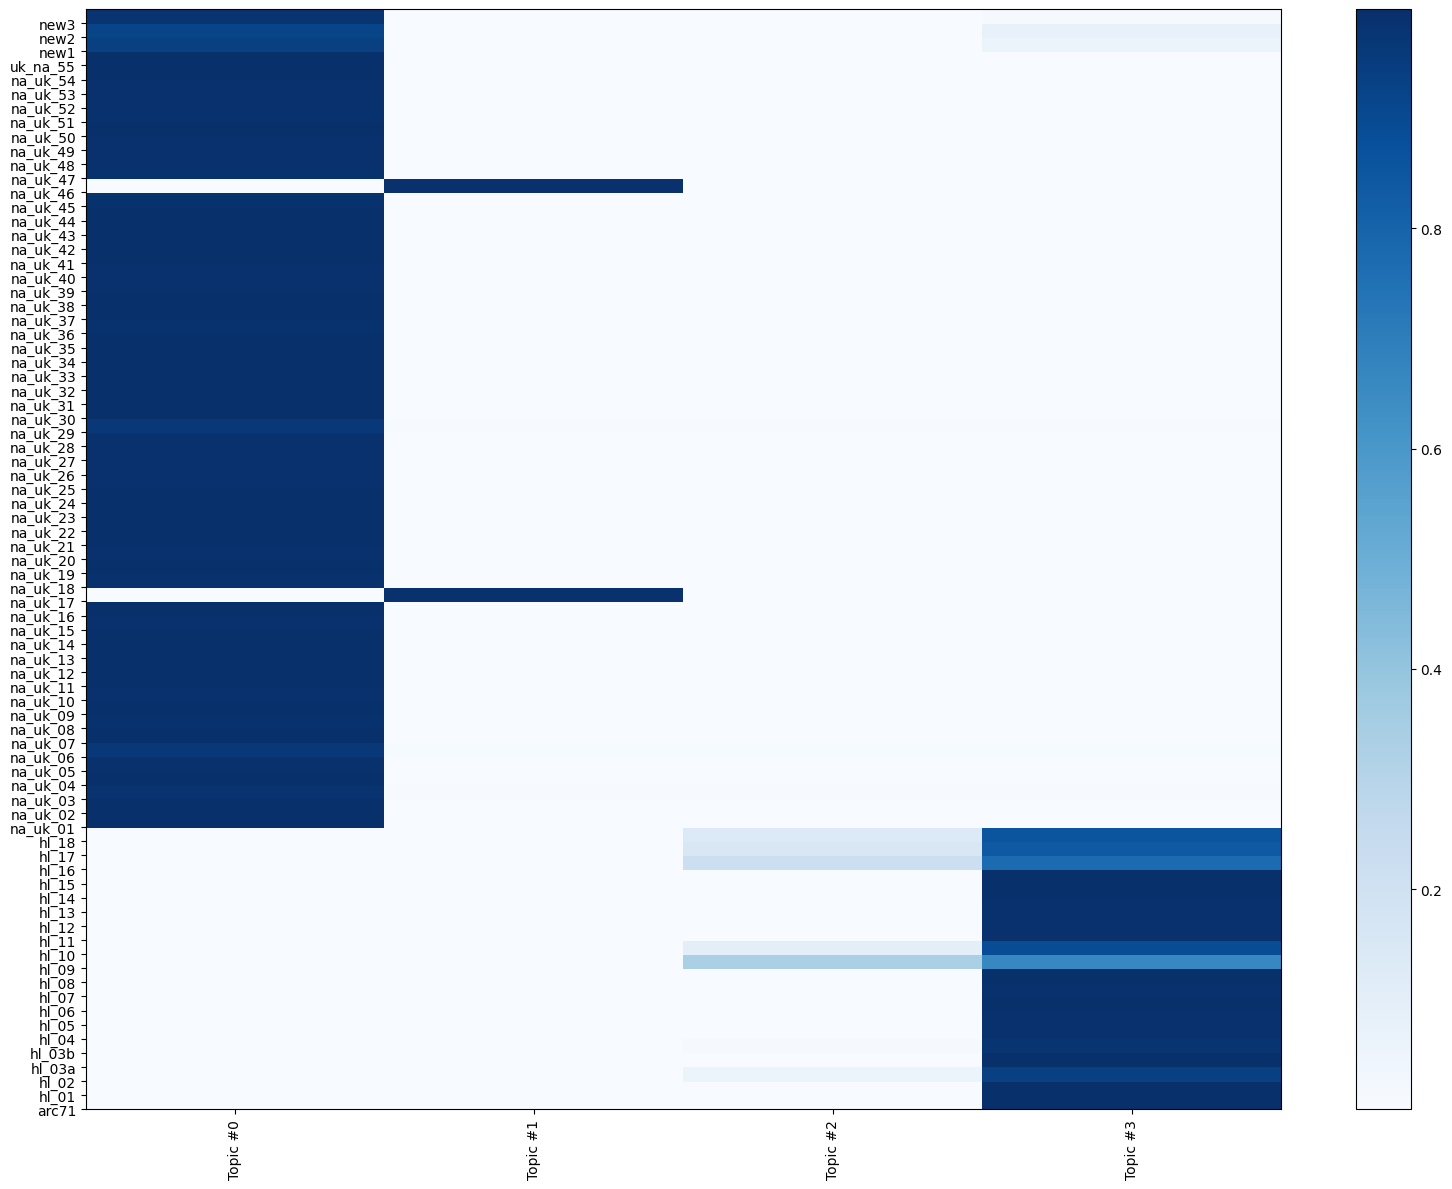

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics, norm=None, cmap='Blues')
plt.yticks(np.arange(doc2topics.shape[0]), docs_id)
plt.xticks(np.arange(doc2topics.shape[1])+0.5, ["Topic #"+str(n) for n in range(inaug_ldamodel.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.show()